<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest_test030821a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

03.08.21
Joining property sales dataset with local schools data (number of secondary schools in radius of 6 km, average weighted disadvantage pupils score, distance to the closest sec school, closest sec school disadv perc, english and math attainment). 
Joining property sales data with historic (3 mnths) median prices per bedroom
RF on all of prop sales data (01/2018 to 02/2020)
Removing outliers (sales prices >=1.5m, bedrooms >5, comparison with historic median>100%)






In [1]:
!pip install harperdb

In [2]:
import harperdb
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
url='https://ce901data-orc0770.harperdbcloud.com'
db=harperdb.HarperDB(url=url,
            username='myuser',
            password='abcdef',
            timeout=500)

In [4]:
db

Below data is extracted from the SQL database, however because of poor performance of the JOIN SQL operations, instead of relational SQL statements, the JOIN operations are performed in pandas DataFrames (according to https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).


The data extraction from SQL tables in placed within the loop to avoid the database timeout issues.

This extracts property sales data.



In [6]:
list_of_dfs = {}
count=0
for mt in range(1, 11):
  for yr in range (2018,2021):
    year=yr
    month=mt
    count=count+1
    #sqlstring1='SELECT bedrooms.id, bedrooms.num_of_beds, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date '
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE (num_of_beds>0 and deed_date LIKE "%{}/{}")'
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE deed_date LIKE "%{}/{}"'
    #sqlstring=sqlstring1+sqlstring2
    sqlstring='SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%{}/{}"'
    sqlstring=sqlstring.format(month,year)
    print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs[count].shape)
df_prop_sales = pd.concat(list_of_dfs, sort=False)
#excluding 'other' property types (i.e. commercial) from the properties sales data 
df_prop_sales=df_prop_sales[(df_prop_sales['property_type']!='O')]
df_prop_sales

SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%1/2018"
(169065, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%1/2019"
(159110, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%1/2020"
(133520, 8)
SELECT propertypurchases.unique_id, propertypurchase

unique_id  price_paid  ...   deed_date postcode
1  0      64342BFD-ABA7-422C-E053-6C04A8C0FB8A     1740000  ...  11/01/2018   E8 4NE
   1      64342BFD-ABAA-422C-E053-6C04A8C0FB8A     1525000  ...  19/01/2018   N5 1BZ
   2      64342BFD-ABAB-422C-E053-6C04A8C0FB8A     3306000  ...  17/01/2018  W11 1NZ
   3      64342BFD-ABAC-422C-E053-6C04A8C0FB8A      442000  ...  04/01/2018  IG3 9NB
   4      64342BFD-ABB0-422C-E053-6C04A8C0FB8A     1375000  ...  12/01/2018  W12 8JN
...                                        ...         ...  ...         ...      ...
30 84973  C18F412B-BE2B-81A6-E053-6B04A8C0AD18      125000  ...  09/10/2020  LS9 9DA
   84974  C18F412B-BEA1-81A6-E053-6B04A8C0AD18      147500  ...  06/10/2020  HD5 9NY
   84975  C18F412B-BEA2-81A6-E053-6B04A8C0AD18      145000  ...  06/10/2020  HD5 9NY
   84977  C18F412B-BEA5-81A6-E053-6B04A8C0AD18      104000  ...  02/10/2020  WF4 6AB
   84979  C18F412B-BEE8-81A6-E053-6B04A8C0AD18      169000  ...  30/10/2020  WF7 5PG

[2563547 rows x 8 columns]

Below extracting number of bedrooms data for each property sale id.


In [7]:
sqlstring='SELECT bedrooms.id, bedrooms.num_of_beds FROM projectdata.bedrooms WHERE num_of_beds>0'
bedrooms=db.sql(sqlstring)
df_bedrooms=pd.DataFrame(bedrooms)
df_bedrooms.rename(columns = {'id':'unique_id'}, inplace = True)
df_bedrooms

,unique_id,num_of_beds
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1
4,8355F008-F016-55C5-E053-6B04A8C0D090,1
...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81


In [8]:
#merging bedrooms data with property sales data.
data = pd.merge(df_bedrooms, df_prop_sales, how="left", on="unique_id")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [9]:
#check rows where postcode is NAN - these are the result of rows added on the Join with bedrooms data where bedrooms data is for sale happened after the considered period
#data_t=data[ (data['postcode'].isnull()) ]
#drop NAN rows from data
data=data.dropna(subset=['postcode'])     
data 

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [10]:
#removing duplicates (some bedroom data was loaded twice by mistake)
data=data.drop_duplicates()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [11]:
#Extracting sales-postcodes-mappings-to-schools-postcodes 
#sales-postcodes-mappings-to-schools-postcodes data is kept in 7 separate SQL tables (due to processing issues with HarperDB)
#Extraction of the data is done from the 7 seprate SQL tables and then the data is merged in one df_local_schools dataframe
list_of_mapping_dfs = {}
sqlstring='SELECT map_sales_pc_to_school_a_c.sales_postcode, map_sales_pc_to_school_a_c.urn, map_sales_pc_to_school_a_c.distance, map_sales_pc_to_school_a_c.disadv_prct, map_sales_pc_to_school_a_c.aver_attain_eng , map_sales_pc_to_school_a_c.aver_attain_math FROM projectdata.map_sales_pc_to_school_a_c'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[1]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_d_i.sales_postcode, map_sales_pc_to_school_d_i.urn, map_sales_pc_to_school_d_i.distance, map_sales_pc_to_school_d_i.disadv_prct, map_sales_pc_to_school_d_i.aver_attain_eng , map_sales_pc_to_school_d_i.aver_attain_math FROM projectdata.map_sales_pc_to_school_d_i'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[2]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_j_m.sales_postcode, map_sales_pc_to_school_j_m.urn, map_sales_pc_to_school_j_m.distance, map_sales_pc_to_school_j_m.disadv_prct, map_sales_pc_to_school_j_m.aver_attain_eng , map_sales_pc_to_school_j_m.aver_attain_math FROM projectdata.map_sales_pc_to_school_j_m'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[3]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_n_q.sales_postcode, map_sales_pc_to_school_n_q.urn, map_sales_pc_to_school_n_q.distance, map_sales_pc_to_school_n_q.disadv_prct, map_sales_pc_to_school_n_q.aver_attain_eng , map_sales_pc_to_school_n_q.aver_attain_math FROM projectdata.map_sales_pc_to_school_n_q'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[4]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_r.sales_postcode, map_sales_pc_to_school_r.urn, map_sales_pc_to_school_r.distance, map_sales_pc_to_school_r.disadv_prct, map_sales_pc_to_school_r.aver_attain_eng , map_sales_pc_to_school_r.aver_attain_math FROM projectdata.map_sales_pc_to_school_r'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[5]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_s.sales_postcode, map_sales_pc_to_school_s.urn, map_sales_pc_to_school_s.distance, map_sales_pc_to_school_s.disadv_prct, map_sales_pc_to_school_s.aver_attain_eng , map_sales_pc_to_school_s.aver_attain_math FROM projectdata.map_sales_pc_to_school_s'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[6]=pd.DataFrame(school_pc_mapping)
sqlstring='SELECT map_sales_pc_to_school_t_z.sales_postcode, map_sales_pc_to_school_t_z.urn, map_sales_pc_to_school_t_z.distance, map_sales_pc_to_school_t_z.disadv_prct, map_sales_pc_to_school_t_z.aver_attain_eng , map_sales_pc_to_school_t_z.aver_attain_math FROM projectdata.map_sales_pc_to_school_t_z'
school_pc_mapping=db.sql(sqlstring)
list_of_mapping_dfs[7]=pd.DataFrame(school_pc_mapping)
df_local_schools = pd.concat(list_of_mapping_dfs, sort=False)
df_local_schools

sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 0             AL1 1AJ  138042  ...              9.4              8.3
  1             AL1 1AJ  138106  ...             12.3             10.8
  2             AL1 1AJ  137038  ...             11.2             11.1
  3             AL1 1AJ  138582  ...             10.6              9.2
  4             AL1 1AJ  117674  ...              2.4              2.3
...                 ...     ...  ...              ...              ...
7 772678        YO8 9XP  144929  ...              9.7              8.3
  772679        YO8 9XP  143138  ...              9.6             10.1
  772680        YO8 9YB  121702  ...              9.4              9.0
  772681        YO8 9YB  143138  ...              9.6             10.1
  772682        YO8 9YE  143138  ...              9.6             10.1

[6520480 rows x 6 columns]

In [12]:
#the school data contains special schools
data_test = df_local_schools[(df_local_schools['disadv_prct']=='NP')]
data_test


sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 532180       BD12 8EW  107589  ...              0.6              0.5
  532213       BD12 8HN  107589  ...              0.6              0.5
  532230       BD12 8HW  107589  ...              0.6              0.5
  532247       BD12 8HY  107589  ...              0.6              0.5
  532264       BD12 8HZ  107589  ...              0.6              0.5
...                 ...     ...  ...              ...              ...
7 618991        WR9 7NJ  117064  ...              4.4              2.7
  618996        WR9 7NL  117064  ...              4.4              2.7
  619001        WR9 7NQ  117064  ...              4.4              2.7
  619006        WR9 7NU  117064  ...              4.4              2.7
  619012        WR9 7NW  117064  ...              4.4              2.7

[25271 rows x 6 columns]

In [13]:
#These two postcodes have to be excluded from the data as these only have special scools in the radius of 6km and, when dropping the special schools from the data, these postcodes do not have any records in the school mapping
data_test1 = data_test[(data_test['sales_postcode'] =='OX15 5SA') | (data_test['sales_postcode'] =='TN8 6JQ' ) ]
data_test1

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math
4,791830,OX15 5SA,123331,2.539054,NP,2.9,4.7
7,57140,TN8 6JQ,125454,5.526534,NP,4.1,2.1


In [14]:
#remove special schools 
df_local_schools.drop(df_local_schools[df_local_schools['disadv_prct']=='NP'].index, inplace = True)
df_local_schools

sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 0             AL1 1AJ  138042  ...              9.4              8.3
  1             AL1 1AJ  138106  ...             12.3             10.8
  2             AL1 1AJ  137038  ...             11.2             11.1
  3             AL1 1AJ  138582  ...             10.6              9.2
  4             AL1 1AJ  117674  ...              2.4              2.3
...                 ...     ...  ...              ...              ...
7 772678        YO8 9XP  144929  ...              9.7              8.3
  772679        YO8 9XP  143138  ...              9.6             10.1
  772680        YO8 9YB  121702  ...              9.4              9.0
  772681        YO8 9YB  143138  ...              9.6             10.1
  772682        YO8 9YE  143138  ...              9.6             10.1

[6495209 rows x 6 columns]

In [15]:
#cheking if the school mappings data contains Nan
data_test = df_local_schools[(df_local_schools['disadv_prct'].isnull())]
data_test

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [16]:
#cheking if the school mappings data contains duplicates
school_map_dupl = df_local_schools[df_local_schools.duplicated()]
school_map_dupl

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [17]:
#check data for a specific sales postcode
data_test4 = df_local_schools[(df_local_schools['sales_postcode'] =='B13 8PG') ]
data_test4

sales_postcode     urn  ...  aver_attain_eng aver_attain_math
1 45525        B13 8PG  141003  ...              9.3              6.9
  45526        B13 8PG  103538  ...              9.5              7.9
  45527        B13 8PG  144464  ...              9.5              9.0
  45528        B13 8PG  140014  ...             11.1              7.7
  45529        B13 8PG  139994  ...             10.5              9.2
  45530        B13 8PG  135970  ...             11.1              8.9
  45531        B13 8PG  103486  ...              9.5              8.8
  45532        B13 8PG  103501  ...             10.5             10.0
  45533        B13 8PG  103514  ...             10.2              8.6
  45534        B13 8PG  103497  ...             11.1              9.7
  45535        B13 8PG  103519  ...              8.2              7.5
  45536        B13 8PG  103560  ...             12.4             10.6
  45537        B13 8PG  137044  ...             16.2             15.1
  45538        B13 8PG  137045  ...             15.5             17.0
  45539        B13 8PG  139797  ...              7.2              5.5
  45540        B13 8PG  136213  ...              9.2              7.8
  45541        B13 8PG  138695  ...              9.0              8.2
  45542        B13 8PG  103531  ...             12.4             11.3
  45543        B13 8PG  145120  ...              8.4              8.1
  45544        B13 8PG  136592  ...             12.2              9.1
  45545        B13 8PG  103606  ...              0.7              0.9
  45546        B13 8PG  136406  ...              9.7              8.5
  45547        B13 8PG  103541  ...              9.1              7.9
  45548        B13 8PG  137858  ...             10.2              8.6
  45549        B13 8PG  135911  ...              9.1              8.0
  45550        B13 8PG  103613  ...              0.1              0.3
  45551        B13 8PG  103498  ...             10.7              8.1
  45552        B13 8PG  138200  ...              8.2              5.4
  45553        B13 8PG  103562  ...             10.6              9.8
  45554        B13 8PG  136590  ...             12.4              9.9
  45555        B13 8PG  141318  ...              8.7              7.3
  45556        B13 8PG  143438  ...             10.6              9.7
  45557        B13 8PG  103632  ...              1.8              1.3
  45558        B13 8PG  103499  ...              9.6              8.1
  45559        B13 8PG  137346  ...             11.5              9.3
  45560        B13 8PG  141835  ...             10.7              9.0
  45561        B13 8PG  137578  ...              9.7              8.0
  45562        B13 8PG  136944  ...             12.3              9.6
  45563        B13 8PG  136924  ...             10.3              9.2
  45564        B13 8PG  130461  ...              1.4              2.3
  45565        B13 8PG  138222  ...              7.6              8.1
  45566        B13 8PG  103493  ...             10.6              8.8

[42 rows x 6 columns]

In [18]:
#adding 'weights' to the school mapping data: calculated as 6km minus the distance from the sale postcode to a school
#the closer a school to the postocode, the greater the weight of that school
df_local_schools['weight']=6-df_local_schools['distance']
df_local_schools['disadv_prct']=df_local_schools['disadv_prct'].str.replace('%','')
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct'].replace(np.nan, 0)  #fillna(0)
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct']. fillna(0)
df_local_schools['disadv_prct']= pd.to_numeric(df_local_schools['disadv_prct'], downcast='float')
df_local_schools

sales_postcode     urn  ...  aver_attain_math    weight
1 0             AL1 1AJ  138042  ...               8.3  4.422326
  1             AL1 1AJ  138106  ...              10.8  5.067710
  2             AL1 1AJ  137038  ...              11.1  4.512236
  3             AL1 1AJ  138582  ...               9.2  4.636620
  4             AL1 1AJ  117674  ...               2.3  3.589736
...                 ...     ...  ...               ...       ...
7 772678        YO8 9XP  144929  ...               8.3  1.906942
  772679        YO8 9XP  143138  ...              10.1  5.299211
  772680        YO8 9YB  121702  ...               9.0  0.579519
  772681        YO8 9YB  143138  ...              10.1  0.917180
  772682        YO8 9YE  143138  ...              10.1  0.188667

[6495209 rows x 7 columns]

In [19]:
#calculating a score for each school mapping
df_local_schools['score_disadv']=df_local_schools['weight'].astype(float)*df_local_schools['disadv_prct'].astype(float)
df_local_schools

sales_postcode     urn  ...    weight  score_disadv
1 0             AL1 1AJ  138042  ...  4.422326    110.558155
  1             AL1 1AJ  138106  ...  5.067710     50.677096
  2             AL1 1AJ  137038  ...  4.512236     45.122361
  3             AL1 1AJ  138582  ...  4.636620    115.915492
  4             AL1 1AJ  117674  ...  3.589736    283.589142
...                 ...     ...  ...       ...           ...
7 772678        YO8 9XP  144929  ...  1.906942     36.231893
  772679        YO8 9XP  143138  ...  5.299211     95.385806
  772680        YO8 9YB  121702  ...  0.579519      9.851820
  772681        YO8 9YB  143138  ...  0.917180     16.509242
  772682        YO8 9YE  143138  ...  0.188667      3.395998

[6495209 rows x 8 columns]

In [20]:
#counting number of secondary schools (in the radius of 6 km) for each sales postcode
g_sch_num = df_local_schools.groupby(['sales_postcode'])['urn'].count().reset_index()
g_sch_num.rename(columns = {'urn':'num_of_sec_sch'}, inplace = True)
g_sch_num.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_sch_num

,postcode,num_of_sec_sch
0,AL1 1AJ,10
1,AL1 1AR,10
2,AL1 1AT,10
3,AL1 1AU,10
4,AL1 1DG,11
...,...,...
580840,YO8 9XL,3
580841,YO8 9XN,3
580842,YO8 9XP,3
580843,YO8 9YB,2


In [21]:
#calculating average weighted disability score for each postcode
g_aver_score_disadv = df_local_schools.groupby(['sales_postcode'])['score_disadv'].mean().reset_index()
g_aver_score_disadv.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_aver_score_disadv

,postcode,score_disadv
0,AL1 1AJ,78.575432
1,AL1 1AR,70.273088
2,AL1 1AT,73.883530
3,AL1 1AU,73.144251
4,AL1 1DG,72.342235
...,...,...
580840,YO8 9XL,70.072425
580841,YO8 9XN,69.052363
580842,YO8 9XP,72.104548
580843,YO8 9YB,13.180531


In [22]:
#For calculating English and Math attainment score for each postcode we'll only consider the most closest school 
#(as taking average score value for all local schools will not be helpful - for example if one closest school in a rural area is 5.9 km away from a property - the distance weighting will diminish the score value)
#extracting the closest schools:
g_closest_schools = df_local_schools.groupby(['sales_postcode'])['distance'].min().reset_index()
g_closest_schools.rename(columns = {'distance':'closest_sch_distance'}, inplace = True)
g_closest_schools

,sales_postcode,closest_sch_distance
0,AL1 1AJ,0.932290
1,AL1 1AR,0.455425
2,AL1 1AT,0.676792
3,AL1 1AU,0.638617
4,AL1 1DG,1.093564
...,...,...
580840,YO8 9XL,0.690030
580841,YO8 9XN,0.742595
580842,YO8 9XP,0.700789
580843,YO8 9YB,5.082820


In [23]:
#joining the closest school table with df_local_schools to obtains english and math attainment for the closest schools
g_closest_schools_with_data = pd.merge(df_local_schools, g_closest_schools, how="left", on="sales_postcode")
g_closest_schools_with_data.drop(g_closest_schools_with_data[g_closest_schools_with_data['distance']!=g_closest_schools_with_data['closest_sch_distance']].index, inplace = True)
g_closest_schools_with_data.rename(columns = {'disadv_prct':'closest_disadv_prct'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_eng':'closest_aver_attain_eng'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_math':'closest_aver_attain_math'}, inplace = True)
g_closest_schools_with_data=g_closest_schools_with_data.drop(['distance', 'weight', 'score_disadv'], axis=1)
g_closest_schools_with_data

,postcode,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
1,AL1 1AJ,138106,10.0,12.3,10.8,0.932290
13,AL1 1AR,138582,25.0,10.6,9.2,0.455425
23,AL1 1AT,138582,25.0,10.6,9.2,0.676792
33,AL1 1AU,138582,25.0,10.6,9.2,0.638617
40,AL1 1DG,138042,25.0,9.4,8.3,1.093564
...,...,...,...,...,...,...
6495199,YO8 9XL,143138,18.0,9.6,10.1,0.690030
6495202,YO8 9XN,143138,18.0,9.6,10.1,0.742595
6495205,YO8 9XP,143138,18.0,9.6,10.1,0.700789
6495207,YO8 9YB,143138,18.0,9.6,10.1,5.082820


In [24]:
#some postcodes will have more than one school at exactly the same closest distance 
data_test2 = g_closest_schools_with_data.groupby(['postcode'])['urn'].count().reset_index()
data_test3=data_test2[(data_test2['urn'] !=1)]
data_test3

,postcode,urn
3342,B13 8PG,2
3343,B13 8PP,2
3344,B13 8PQ,2
3733,B14 6AB,2
3736,B14 6AH,2
...,...,...
573712,WV6 8PH,2
573713,WV6 8PJ,2
573715,WV6 8PP,2
573716,WV6 8PQ,2


In [25]:
#chosing maximum closest_disadv_prct,	closest_aver_attain_eng,	closest_aver_attain_math for each sales postcode
g_closest_schools_max1 = g_closest_schools_with_data.groupby(['postcode'])['closest_disadv_prct'].max().reset_index()
g_closest_schools_max2 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_eng'].max().reset_index()
g_closest_schools_max3 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_math'].max().reset_index()
g_closest_schools_max4 = g_closest_schools_with_data.groupby(['postcode'])['closest_sch_distance'].max().reset_index()
g_closest_schools_with_data_max=pd.merge(g_closest_schools_max1,g_closest_schools_max2, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max3, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max4, how="left", on="postcode")
g_closest_schools_with_data_max

,postcode,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10.0,12.3,10.8,0.932290
1,AL1 1AR,25.0,10.6,9.2,0.455425
2,AL1 1AT,25.0,10.6,9.2,0.676792
3,AL1 1AU,25.0,10.6,9.2,0.638617
4,AL1 1DG,25.0,9.4,8.3,1.093564
...,...,...,...,...,...
580840,YO8 9XL,18.0,9.6,10.1,0.690030
580841,YO8 9XN,18.0,9.6,10.1,0.742595
580842,YO8 9XP,18.0,9.6,10.1,0.700789
580843,YO8 9YB,18.0,9.6,10.1,5.082820


In [26]:
#join all school data together
#for each prop sales postcode we have number of secondary schools in radius 6 km, weighted average disadvantage score, closest school disadv %, closest sch eng and math attaint, closest sch distance
#alltogether 6 features related to schools data
prepared_sch_data = pd.merge(g_sch_num, g_aver_score_disadv, how="left", on="postcode")
prepared_sch_data = pd.merge(prepared_sch_data, g_closest_schools_with_data_max, how="left", on="postcode")
prepared_sch_data

,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10,78.575432,10.0,12.3,10.8,0.932290
1,AL1 1AR,10,70.273088,25.0,10.6,9.2,0.455425
2,AL1 1AT,10,73.883530,25.0,10.6,9.2,0.676792
3,AL1 1AU,10,73.144251,25.0,10.6,9.2,0.638617
4,AL1 1DG,11,72.342235,25.0,9.4,8.3,1.093564
...,...,...,...,...,...,...,...
580840,YO8 9XL,3,70.072425,18.0,9.6,10.1,0.690030
580841,YO8 9XN,3,69.052363,18.0,9.6,10.1,0.742595
580842,YO8 9XP,3,72.104548,18.0,9.6,10.1,0.700789
580843,YO8 9YB,2,13.180531,18.0,9.6,10.1,5.082820


In [27]:
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD
...,...,...,...,...,...,...,...,...,...
1231571,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG
1231572,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ
1231573,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY
1231574,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL


In [28]:
#append prepared_sch_data to data
data = pd.merge(data, prepared_sch_data, how="left", on="postcode")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274


In [29]:
#checking where num_of_sec_sch is NAN 
data_nan_sch = data[(data['num_of_sec_sch'].isnull())]
data_nan_sch

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
44845,6B32222C-8D7F-01F1-E053-6C04A8C0D2C8,2,220000.0,BANBURY,CHERWELL,F,S,10/04/2018,OX15 5SA,NaN,NaN,NaN,NaN,NaN,NaN
53389,919FEC05-A068-9A90-E053-6C04A8C0A300,2,320000.0,BANBURY,CHERWELL,F,T,02/08/2019,OX15 5NF,NaN,NaN,NaN,NaN,NaN,NaN
74857,80E1AA98-36C5-7BF8-E053-6C04A8C00BF2,2,244000.0,EDENBRIDGE,SEVENOAKS,L,F,15/11/2018,TN8 6JQ,NaN,NaN,NaN,NaN,NaN,NaN
79586,A71375FD-DDA6-7576-E053-6C04A8C0462F,2,220000.0,BANBURY,CHERWELL,F,S,28/02/2020,OX15 5LQ,NaN,NaN,NaN,NaN,NaN,NaN
87682,9B361206-5C76-1904-E053-6B04A8C0EEB5,2,155000.0,EDENBRIDGE,SEVENOAKS,L,T,02/09/2019,TN8 6GH,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199957,773788C2-C1E8-2CE4-E053-6C04A8C05E57,5,538000.0,EDENBRIDGE,SEVENOAKS,F,D,10/09/2018,TN8 6GB,NaN,NaN,NaN,NaN,NaN,NaN
1202369,8F1B26BE-11D6-53DB-E053-6C04A8C03649,5,915000.0,BANBURY,CHERWELL,F,D,24/07/2019,OX15 5ND,NaN,NaN,NaN,NaN,NaN,NaN
1211609,773788C3-09C1-2CE4-E053-6C04A8C05E57,6,1840000.0,BANBURY,CHERWELL,F,D,31/08/2018,OX15 5BL,NaN,NaN,NaN,NaN,NaN,NaN
1212517,8A78B2AF-AB7D-5CB0-E053-6B04A8C0F504,6,527500.0,EDENBRIDGE,SEVENOAKS,F,D,17/05/2019,TN8 6GB,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274


In [31]:
#column to represent historic point: 01-2018=>1, 02-2018=>2 etc
#hist_mnth=12*(year-2018)+month
data['hist_mnth']=data['deed_date'].str.split('/').str[1].astype(int)+ 12*(data['deed_date'].str.split('/').str[2].astype(int)-2018)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16


In [32]:
#extracting historic (3 months) median price per bedroom for each postal area
sqlstring='SELECT  median_hist_3mth_ppb.postcode_area_m_y,  median_hist_3mth_ppb.median_ppb_3mnths_ago FROM projectdata.median_hist_3mth_ppb'
hist_median_ppb=db.sql(sqlstring)
df_hist_median_ppb=pd.DataFrame(hist_median_ppb)
df_hist_median_ppb

,postcode_area_m_y,median_ppb_3mnths_ago
0,AL10_01_2018,117916.66670
1,AL10_01_2019,121666.66670
2,AL10_01_2020,123112.50000
3,AL10_02_2018,121666.66670
4,AL10_02_2019,126666.66670
...,...,...
62259,YO8_10_2019,60916.66667
62260,YO8_11_2018,62083.33333
62261,YO8_11_2019,58000.00000
62262,YO8_12_2018,65500.00000


In [33]:
#field for merging with historic median prices per bedroom
data['postcode_area_m_y']=data['postcode'].str.split(' ').str[0]+'_'+data['deed_date'].str.split('/').str[1]+'_'+data['deed_date'].str.split('/').str[2]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219325,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019
1219326,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019
1219327,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019
1219328,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019


In [34]:
#merging the dataset with median historic prices per bedroom
data = pd.merge(data, df_hist_median_ppb, how="left", on="postcode_area_m_y")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000


In [35]:
#checking where median_ppb_3mnths_ago is NAN 
data_nan_median_historic_ppb = data[(data['median_ppb_3mnths_ago'].isnull())]
data_nan_median_historic_ppb

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
545,75050A84-D2F3-9A88-E053-6B04A8C02390,1,97000.0,LISKEARD,CORNWALL,F,S,20/07/2018,PL14 3QN,1.0,199.732649,39.0,8.8,7.6,0.878650,7,PL14_07_2018,NaN
579,773788C2-5C25-2CE4-E053-6C04A8C05E57,1,134500.0,BOSCASTLE,CORNWALL,F,T,16/08/2018,PL35 0AL,1.0,0.000000,0.0,0.0,0.0,0.000000,8,PL35_08_2018,NaN
853,8F1B26BD-E807-53DB-E053-6C04A8C03649,1,97000.0,MANCHESTER,MANCHESTER,L,F,24/05/2019,M13 0DB,27.0,89.273531,70.0,8.3,8.1,1.333832,17,M13_05_2019,NaN
1243,7E86B6FB-1C9D-458C-E053-6B04A8C0C84C,1,450000.0,LONDON,ISLINGTON,L,F,17/08/2018,WC1X 9AA,80.0,106.458651,64.0,11.2,9.0,0.669889,8,WC1X_08_2018,NaN
1264,7C2D0700-652F-4963-E053-6B04A8C07B97,1,129000.0,CHATHILL,NORTHUMBERLAND,F,T,15/10/2018,NE67 5BP,1.0,0.000000,0.0,0.0,0.0,0.000000,10,NE67_10_2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218793,75050A85-D125-9A88-E053-6B04A8C02390,8,857500.0,CORWEN,DENBIGHSHIRE,F,D,19/07/2018,LL21 9EG,1.0,0.000000,0.0,0.0,0.0,0.000000,7,LL21_07_2018,NaN
1218795,7011B109-2063-8ED6-E053-6B04A8C075C1,8,215000.0,PORT ISAAC,CORNWALL,F,T,05/06/2018,PL29 3SR,1.0,0.000000,0.0,0.0,0.0,0.000000,6,PL29_06_2018,NaN
1218889,75050A85-D022-9A88-E053-6B04A8C02390,9,230000.0,BARMOUTH,GWYNEDD,F,T,13/08/2018,LL42 1NA,1.0,0.000000,0.0,0.0,0.0,0.000000,8,LL42_08_2018,NaN
1219104,93E6821F-1D1A-40FD-E053-6B04A8C0C1DF,11,585000.0,BRISTOL,CITY OF BRISTOL,F,T,13/09/2019,BS1 6SX,21.0,81.072324,17.0,11.8,10.0,0.355128,21,BS1_09_2019,NaN


In [36]:
#Checking how many postal areas do not have median_ppb_3mnths_ago
g_test = data_nan_median_historic_ppb.groupby(['postcode_area_m_y'])['unique_id'].count().reset_index()
g_test.rename(columns = {'unique_id':'num of prop transactions'}, inplace = True)
g_test

,postcode_area_m_y,num of prop transactions
0,B18_04_2019,7
1,B19_06_2018,1
2,B1_02_2020,2
3,B1_10_2019,1
4,B3_09_2018,1
...,...,...
992,YO1_03_2019,5
993,YO51_06_2018,5
994,YO60_04_2018,4
995,YO60_04_2019,2


In [37]:
#removing from the dataset those transactions which do not have the historic median ppb info 
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000


In [38]:
#calculate each price per bedroom for comparing with historic median ppd
data['this_price_per_bedroom']=data['price_paid']/data['num_of_beds']
data['compare_ppd_re_hist_median']=100*(data['this_price_per_bedroom']-data['median_ppb_3mnths_ago'])/data['median_ppb_3mnths_ago']
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.000000,65.975104
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79500.000000,0.421053
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.000000,74.347333
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,314000.000000,6.440678
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,170000.000000,67.213115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,1680.851064,-95.532622
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,1104.166667,-97.239583
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,1272.727273,-96.920821
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,1172.839506,-97.828075


In [39]:
#outliers
#see those transactions where ppd is over (or under) 100% of median historic ppd
data_out = data[(data['compare_ppd_re_hist_median'] >100) | (data['compare_ppd_re_hist_median'] <-100) ]
data_out

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
5,8F1B26BE-306C-53DB-E053-6C04A8C03649,1,655000.0,GUILDFORD,GUILDFORD,F,S,10/06/2019,GU1 3LN,6.0,55.701643,14.0,11.9,11.0,1.752959,18,GU1_06_2019,136666.66670,6.550000e+05,379.268293
7,8A78B2AF-DA77-5CB0-E053-6B04A8C0F504,1,142500.0,NORTHAMPTON,NORTHAMPTON,L,S,29/03/2019,NN3 2NQ,11.0,105.275240,27.0,8.2,7.8,0.406383,15,NN3_03_2019,70833.33333,1.425000e+05,101.176471
9,9FF0D96A-7586-11ED-E053-6C04A8C06383,1,550000.0,BRIGHTON,BRIGHTON AND HOVE,F,T,31/01/2020,BN2 0BS,9.0,75.360125,16.0,10.7,10.2,2.686117,25,BN2_01_2020,154605.00000,5.500000e+05,255.745286
15,965B6D92-339B-95E4-E053-6C04A8C07729,1,460000.0,LONDON,GREENWICH,F,T,07/10/2019,SE18 7BL,32.0,84.918178,45.0,9.2,7.6,1.169695,22,SE18_10_2019,159500.00000,4.600000e+05,188.401254
20,726BF13B-1D38-0A46-E053-6C04A8C01D0D,1,145500.0,SUTTON-IN-ASHFIELD,ASHFIELD,F,D,13/07/2018,NG17 5DW,10.0,96.495707,38.0,8.5,7.8,0.501127,7,NG17_07_2018,44458.33333,1.455000e+05,227.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219007,AC07BBD0-C0AB-0445-E053-6C04A8C01E31,10,13250000.0,WINDLESHAM,SURREY HEATH,F,D,26/02/2020,GU20 6PP,3.0,28.766940,12.0,11.4,10.3,2.111534,26,GU20_02_2020,172666.66670,1.325000e+06,667.374517
1219015,8F1B26BD-BB55-53DB-E053-6C04A8C03649,10,5300000.0,NEWBURY,BASINGSTOKE AND DEANE,F,D,14/06/2019,RG20 9RJ,3.0,26.978905,20.0,8.7,9.4,2.939459,18,RG20_06_2019,159975.00000,5.300000e+05,231.301766
1219098,93E6821E-99F2-40FD-E053-6B04A8C0C1DF,11,25500000.0,LONDON,CITY OF WESTMINSTER,F,T,29/08/2019,SW1X 8SA,62.0,85.288007,37.0,10.3,9.7,1.035724,20,SW1X_08_2019,975000.00000,2.318182e+06,137.762238
1219108,6B32222C-9D73-01F1-E053-6C04A8C0D2C8,11,2255000.0,NEWMARKET,FOREST HEATH,F,D,29/03/2018,CB8 7BT,1.0,105.615606,25.0,9.0,8.1,1.775376,3,CB8_03_2018,101000.00000,2.050000e+05,102.970297


In [40]:
#remove outliers
data = data[(data['compare_ppd_re_hist_median'] <=100) & (data['compare_ppd_re_hist_median'] >=-100) ]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.000000,65.975104
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79500.000000,0.421053
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.000000,74.347333
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,314000.000000,6.440678
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,170000.000000,67.213115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219182,8355F009-2B4F-55C5-E053-6B04A8C0D090,47,79000.0,LEIGH,WIGAN,L,T,08/02/2019,WN7 1NG,12.0,72.452903,39.0,8.5,7.5,1.542007,14,WN7_02_2019,37625.00000,1680.851064,-95.532622
1219183,8A78B2B0-784A-5CB0-E053-6B04A8C0F504,48,53000.0,BLACKWOOD,CAERPHILLY,F,S,12/04/2019,NP12 3LQ,1.0,0.000000,0.0,0.0,0.0,0.000000,16,NP12_04_2019,40000.00000,1104.166667,-97.239583
1219184,8355F009-8A15-55C5-E053-6B04A8C0D090,55,70000.0,FLINT,FLINTSHIRE,F,T,11/02/2019,CH6 5DY,1.0,0.000000,0.0,0.0,0.0,0.000000,14,CH6_02_2019,41333.33333,1272.727273,-96.920821
1219185,8A78B2B0-4326-5CB0-E053-6B04A8C0F504,81,95000.0,TODMORDEN,CALDERDALE,L,T,08/04/2019,OL14 8NL,1.0,88.443148,25.0,9.7,7.7,2.462274,16,OL14_04_2019,54000.00000,1172.839506,-97.828075


In [41]:
data = data[(data['num_of_beds'] <=5) & (data['price_paid'] <1500000) ]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.0,65.975104
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79500.0,0.421053
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.0,74.347333
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,314000.0,6.440678
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,170000.0,67.213115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,87E1551E-0B78-6405-E053-6C04A8C0B2EE,5,570000.0,SHERBORNE,DORSET,F,D,08/04/2019,DT9 6NT,1.0,0.000000,0.0,0.0,0.0,0.000000,16,DT9_04_2019,90750.00000,114000.0,25.619835
1207158,6DA08449-E135-30F2-E053-6B04A8C05F3B,5,890000.0,MANCHESTER,MANCHESTER,F,D,30/04/2018,M20 2WG,24.0,97.697793,97.0,1.9,2.8,1.639435,4,M20_04_2018,105000.00000,178000.0,69.523810
1207159,79A74E21-A664-1289-E053-6B04A8C01627,5,328000.0,HASTINGS,HASTINGS,F,S,24/09/2018,TN34 2EJ,6.0,193.121503,26.0,8.7,8.3,1.094252,9,TN34_09_2018,86666.66667,65600.0,-24.307692
1207160,666758D6-F397-3363-E053-6B04A8C0D74E,5,214000.0,PRESTON,SOUTH RIBBLE,F,D,02/02/2018,PR5 0AB,6.0,46.650826,27.0,9.5,8.1,2.156095,2,PR5_02_2018,57750.00000,42800.0,-25.887446


In [42]:
data_select1 = data
data_select1

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.0,65.975104
1,9B361206-34DE-1904-E053-6B04A8C0EEB5,1,79500.0,MANCHESTER,BURY,L,S,08/11/2019,M25 1ET,24.0,78.275669,15.0,10.8,9.4,0.320619,23,M25_11_2019,79166.66667,79500.0,0.421053
2,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.0,74.347333
3,A71375FD-EBA1-7576-E053-6C04A8C0462F,1,314000.0,LONDON,LAMBETH,L,F,21/02/2020,SW12 0JP,54.0,92.304597,36.0,11.4,9.6,0.543902,26,SW12_02_2020,295000.00000,314000.0,6.440678
4,8355F008-F016-55C5-E053-6B04A8C0D090,1,170000.0,BRAINTREE,BRAINTREE,L,F,01/02/2019,CM7 1TD,3.0,89.636307,13.0,9.7,8.3,0.452391,14,CM7_02_2019,101666.66670,170000.0,67.213115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,87E1551E-0B78-6405-E053-6C04A8C0B2EE,5,570000.0,SHERBORNE,DORSET,F,D,08/04/2019,DT9 6NT,1.0,0.000000,0.0,0.0,0.0,0.000000,16,DT9_04_2019,90750.00000,114000.0,25.619835
1207158,6DA08449-E135-30F2-E053-6B04A8C05F3B,5,890000.0,MANCHESTER,MANCHESTER,F,D,30/04/2018,M20 2WG,24.0,97.697793,97.0,1.9,2.8,1.639435,4,M20_04_2018,105000.00000,178000.0,69.523810
1207159,79A74E21-A664-1289-E053-6B04A8C01627,5,328000.0,HASTINGS,HASTINGS,F,S,24/09/2018,TN34 2EJ,6.0,193.121503,26.0,8.7,8.3,1.094252,9,TN34_09_2018,86666.66667,65600.0,-24.307692
1207160,666758D6-F397-3363-E053-6B04A8C0D74E,5,214000.0,PRESTON,SOUTH RIBBLE,F,D,02/02/2018,PR5 0AB,6.0,46.650826,27.0,9.5,8.1,2.156095,2,PR5_02_2018,57750.00000,42800.0,-25.887446


In [43]:
points=data_select1['district'].unique()
points.sort()
print(len(points))

353


In [44]:
# Remove columns 
data_select1.drop(['unique_id' ,'town', 'district','deed_date','postcode','postcode_area_m_y' ,'this_price_per_bedroom','compare_ppd_re_hist_median' ],  axis='columns', inplace=True)
data_select1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago
0,1,100000.0,L,T,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000
1,1,79500.0,L,S,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667
2,1,128000.0,L,F,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667
3,1,314000.0,L,F,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000
4,1,170000.0,L,F,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,5,570000.0,F,D,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000
1207158,5,890000.0,F,D,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000
1207159,5,328000.0,F,S,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667
1207160,5,214000.0,F,D,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000


In [45]:
estateTypes=data_select1['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [46]:
data_select1['estate_type'] =data_select1['estate_type'].map({'F':'2',
                             'L':'1'})
data_select1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago
0,1,100000.0,1,T,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000
1,1,79500.0,1,S,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667
2,1,128000.0,1,F,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667
3,1,314000.0,1,F,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000
4,1,170000.0,1,F,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,5,570000.0,2,D,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000
1207158,5,890000.0,2,D,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000
1207159,5,328000.0,2,S,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667
1207160,5,214000.0,2,D,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000


In [47]:
propertyTypes=data_select1['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [48]:
data_select1['property_type'] =data_select1['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
data_select1
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago
0,1,100000.0,1,2,23.0,110.178111,96.0,0.5,0.9,0.671216,7,60250.00000
1,1,79500.0,1,3,24.0,78.275669,15.0,10.8,9.4,0.320619,23,79166.66667
2,1,128000.0,1,1,12.0,85.979811,20.0,11.5,9.8,0.584296,4,73416.66667
3,1,314000.0,1,1,54.0,92.304597,36.0,11.4,9.6,0.543902,26,295000.00000
4,1,170000.0,1,1,3.0,89.636307,13.0,9.7,8.3,0.452391,14,101666.66670
...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,5,570000.0,2,4,1.0,0.000000,0.0,0.0,0.0,0.000000,16,90750.00000
1207158,5,890000.0,2,4,24.0,97.697793,97.0,1.9,2.8,1.639435,4,105000.00000
1207159,5,328000.0,2,3,6.0,193.121503,26.0,8.7,8.3,1.094252,9,86666.66667
1207160,5,214000.0,2,4,6.0,46.650826,27.0,9.5,8.1,2.156095,2,57750.00000


In [49]:
#df1= data.pop('price_paid') # remove column price_paid and store it in df1
#data['price_paid']=df1 # add price_paid series as a 'new' column.
#data
df_data_new = data_select1.loc[:, ['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','hist_mnth',	'price_paid']]
df_data_new


,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,hist_mnth,price_paid
0,1,1,2,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,7,100000.0
1,1,1,3,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,23,79500.0
2,1,1,1,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,4,128000.0
3,1,1,1,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,26,314000.0
4,1,1,1,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,14,170000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1207157,5,2,4,1.0,0.000000,0.000000,0.0,0.0,0.0,90750.00000,16,570000.0
1207158,5,2,4,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.00000,4,890000.0
1207159,5,2,3,6.0,193.121503,1.094252,26.0,8.7,8.3,86666.66667,9,328000.0
1207160,5,2,4,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.00000,2,214000.0


In [50]:
#shuffle the dataset
df_data_new = df_data_new.sample(frac = 1)
df_data_new

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,hist_mnth,price_paid
58071,2,1,1,2.0,97.764700,0.612462,16.0,10.7,10.0,148750.00000,20,79500.0
44154,2,1,1,9.0,52.712423,1.172840,13.0,11.0,9.7,91083.33333,11,190000.0
816954,3,2,3,1.0,103.123564,3.421911,40.0,9.8,8.5,29000.00000,1,117000.0
1083433,4,2,2,6.0,29.222750,1.660709,6.0,11.4,11.4,136108.33330,10,590000.0
525806,3,2,3,7.0,30.354298,0.983277,21.0,8.8,7.5,182166.66670,12,413000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
582760,3,2,3,1.0,82.978349,0.813853,16.0,9.5,8.6,105250.00000,19,375000.0
182149,2,2,2,7.0,92.331024,1.107262,54.0,7.2,5.4,92500.00000,19,270000.0
953896,4,1,2,17.0,105.614610,0.289395,64.0,8.5,7.3,43750.00000,26,205000.0
1007498,4,2,4,1.0,9.800401,5.183300,12.0,10.8,9.7,152708.33330,15,550000.0


In [51]:
dataset = df_data_new.values
dataset

array([[2, '1', '1', ..., 148750.0, 20, 79500.0],
       [2, '1', '1', ..., 91083.33333, 11, 190000.0],
       [3, '2', '3', ..., 29000.0, 1, 117000.0],
       ...,
       [4, '1', '2', ..., 43750.0, 26, 205000.0],
       [4, '2', '4', ..., 152708.3333, 15, 550000.0],
       [4, '2', '4', ..., 74833.33333, 4, 450000.0]], dtype=object)

In [53]:
X1 = dataset[:,0:11]
Y1 = dataset[:,11]
#all features

In [54]:
from sklearn import preprocessing

In [55]:
min_max_scaler = preprocessing.MinMaxScaler()

In [56]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 0.        , 0.        , ..., 0.57803468, 0.03363572,
        0.76      ],
       [0.25      , 0.        , 0.        , ..., 0.56069364, 0.02004791,
        0.4       ],
       [0.5       , 1.        , 0.66666667, ..., 0.49132948, 0.00541942,
        0.        ],
       ...,
       [0.75      , 0.        , 0.33333333, ..., 0.42196532, 0.00889491,
        1.        ],
       [0.75      , 1.        , 1.        , ..., 0.56069364, 0.03456841,
        0.56      ],
       [0.75      , 1.        , 1.        , ..., 0.08092486, 0.01621898,
        0.12      ]])

In [57]:

print(min(Y1))
print(max(Y1))

1.0
1499999.0


In [58]:
from sklearn.model_selection import train_test_split

In [74]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [75]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(1052951, 11) (116995, 11) (1052951,) (116995,)


In [76]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [91]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [92]:


prediction_df1 = pd.DataFrame(X1_test)
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1

,0,1,2,3,4,5,6,7,8,9,10,Y1,predictions1,error1,sq_error1,root_sq_error1
0,0.50,0.0,0.000000,0.792683,0.242967,0.125795,0.58,0.547619,0.421965,0.064365,0.64,740000,582512.154303,157488,2.48024e+10,157488
1,0.50,0.0,0.666667,0.048780,0.122022,0.342761,0.35,0.541667,0.491329,0.010525,0.48,175000,148987.922874,26012.1,6.76628e+08,26012.1
2,0.50,1.0,0.666667,0.182927,0.174542,0.291347,0.24,0.619048,0.491329,0.015767,0.88,150000,208310.308723,-58310.3,3.40009e+09,58310.3
3,0.50,1.0,0.333333,0.231707,0.165504,0.229475,0.26,0.714286,0.583815,0.012488,0.36,167550,152602.603642,14947.4,2.23425e+08,14947.4
4,0.50,1.0,0.333333,0.414634,0.197128,0.212774,0.50,0.125000,0.063584,0.012115,0.88,157500,151259.856757,6240.14,3.89394e+07,6240.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116990,0.50,1.0,0.666667,0.256098,0.176248,0.138449,0.56,0.529762,0.387283,0.011251,0.76,98000,162118.210154,-64118.2,4.11114e+09,64118.2
116991,0.50,1.0,0.666667,0.463415,0.122769,0.108650,0.31,0.571429,0.491329,0.032163,0.24,435000,456253.750728,-21253.8,4.51722e+08,21253.8
116992,0.50,1.0,0.333333,0.317073,0.170123,0.062529,0.42,0.613095,0.578035,0.026861,0.92,310000,327506.276755,-17506.3,3.0647e+08,17506.3
116993,0.25,1.0,0.333333,0.036585,0.155259,0.147265,0.43,0.523810,0.468208,0.009209,0.92,90000,84136.889107,5863.11,3.43761e+07,5863.11


In [93]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

71600.49139204793

In [94]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')

Predictions where error is 10% or less :36.5810504722424 %
Predictions where error is 15% or less :51.55263045429292 %


In [95]:
import matplotlib.pyplot as plt

In [96]:
import numpy as np

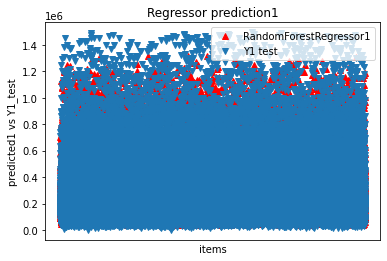

In [97]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

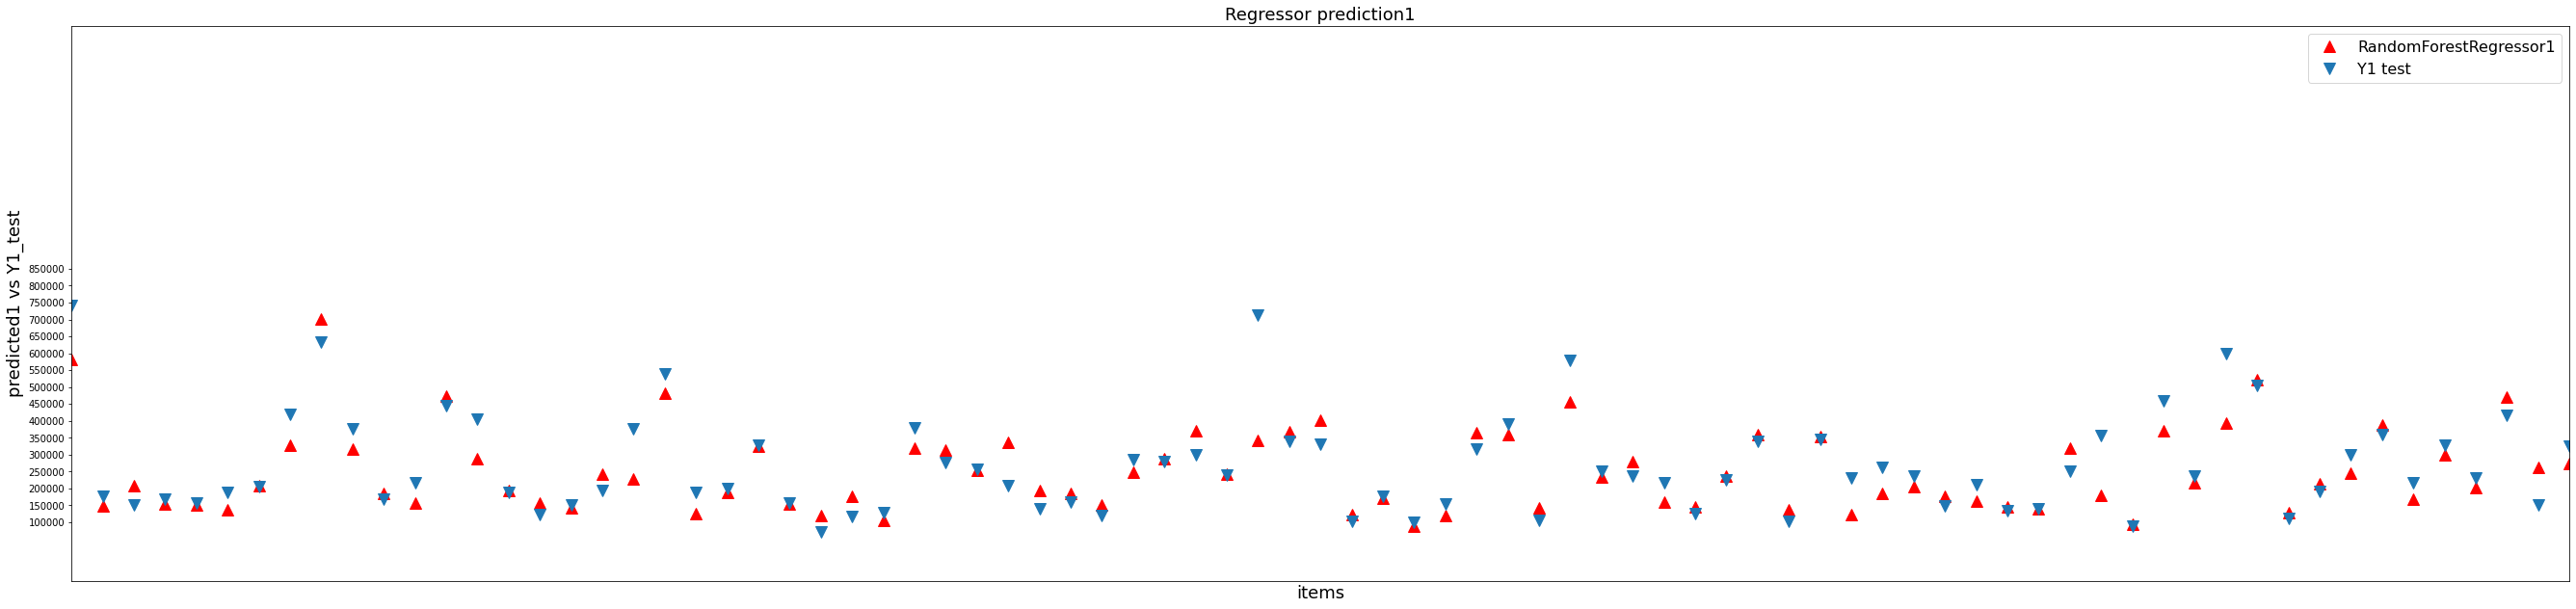

In [98]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000])
plt.yticks(np.arange(y.min(), y.max(), 50000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,80])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [99]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [100]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

71600.49139204824

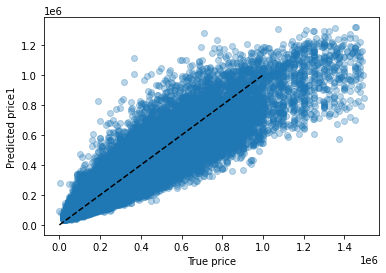

In [101]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()
